In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [33]:
strSource = r"D:\ML\data\StadtteilprofileBerichtsjahr2018_endversion.csv"
df = pd.read_csv(strSource, sep=';', header=0, encoding='iso-8859-1')

In [34]:
def createIndex(df):
    #Create Coumn ID and set as Index
    newIndex = []
    for i in df.index:
        i += 1
        newIndex.append("ST" + str(i))

    df['id'] = newIndex
    dfi = df.set_index('id')
    return dfi

df = createIndex(df)

In [35]:
df = df.dropna(axis='columns')

scaler = preprocessing.StandardScaler()
array_scaled = scaler.fit_transform(df.loc[:,df.columns.difference(['Stadtteil'])])
dfs = pd.DataFrame(array_scaled,columns = df.columns.difference(['Stadtteil']))
dfs.cov().to_csv(r"D:\ML\work\Korrelationsmatrix.csv", sep=';', na_rep='NaN', index=True)

In [36]:
pca = PCA(n_components=0.95)
array_pc = pca.fit(dfs).transform(dfs)
print(pd.DataFrame(pca.explained_variance_ratio_))
print('Anzahl Hauptkomponenten: ' + str(pca.components_.shape[0]))

0
0   0.461172
1   0.185561
2   0.129668
3   0.032940
4   0.028806
5   0.027496
6   0.022767
7   0.017476
8   0.013959
9   0.011174
10  0.009634
11  0.008792
12  0.007671
Anzahl Hauptkomponenten: 13


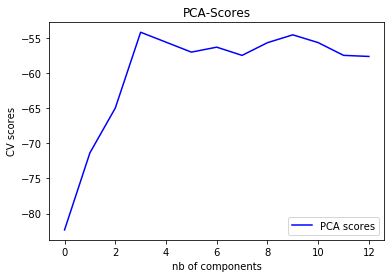

In [37]:
pca_scores = []
for n in range(pca.components_.shape[0]):
    pca.n_components = n
    pca_scores.append(np.mean(cross_val_score(pca, dfs)))
    
plt.figure()
n_components = np.arange(0, pca.n_components+1, 1)
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('PCA-Scores')
plt.show()

In [38]:
pca = PCA(n_components=9)
array_pc = pca.fit(dfs).transform(dfs)
dfp = pd.DataFrame(array_pc)
dfp = createIndex(dfp)

In [39]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

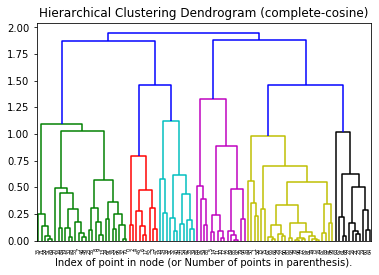

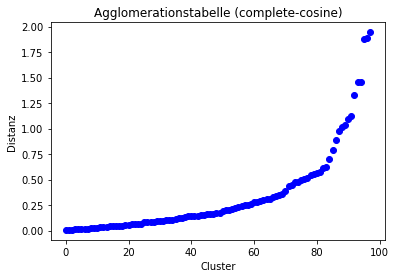

In [40]:
methode='complete'; distanz='cosine'
model = AgglomerativeClustering(n_clusters=None, affinity=distanz, linkage=methode, distance_threshold=0)
model = model.fit(dfp)

#Dendrogram
plt.figure()
plt.title('Hierarchical Clustering Dendrogram '+ '(' + methode + '-' + distanz + ')')
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Index of point in node (or Number of points in parenthesis).")
    
#Agglomerationstabelle
plt.figure()
plt.title('Agglomerationstabelle ' + '(' + methode + '-' + distanz + ')')
plt.plot(model.distances_, "ob")
plt.xlabel('Cluster')
plt.ylabel('Distanz')
plt.show()

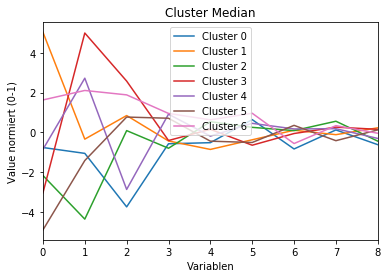

In [41]:
clusterZahl=7
model = AgglomerativeClustering(n_clusters=clusterZahl,  affinity=distanz, linkage=methode, distance_threshold=None)
cluster = model.fit_predict(dfp)
dfp['Cluster'] = pd.Series(cluster, index=dfp.index)

dfm = pd.merge(dfp, df.loc[:,['Stadtteil']], on='id')
dfm.to_csv(r"D:\ML\work\pca_StadtteilprofileBerichtsjahr2018_5.csv", sep=';', na_rep='NaN', index=True)

dfSeries = pd.DataFrame()
for i in range(model.n_clusters_):
    dfm_plot = dfm.loc[dfp['Cluster'] == i]
    dfm_plot = dfm_plot.loc[:,dfm.columns.difference(['Cluster','Stadtteil'])]
    s = dfm_plot.median().round(3)
    s.name = 'Cluster ' + str(i)
    s.plot.line()
    dfSeries = dfSeries.append(s)

filePath = "D:/ML/work/" + methode + "_" + distanz + "_" + str(clusterZahl) + ".csv"
dfSeries.to_csv(filePath, sep=';', na_rep='NaN', index=True)
 
plt.title('Cluster Median')
plt.xlabel('Variablen')
plt.ylabel('Value normiert (0-1)')
plt.legend()
plt.show()